In [4]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from models import Uni_Sign
import utils as utils
from datasets import S2T_Dataset
import os
import time
import argparse, json, datetime
from pathlib import Path
import math
import sys
from timm.optim import create_optimizer
from models import get_requires_grad_dict
from SLRT_metrics import translation_performance, islr_performance, wer_list
from transformers import get_scheduler
from config import *

/home/dial/anaconda3/envs/jonghyo_unisign/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-04-07 09:53:33,013] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/dial/anaconda3/envs/jonghyo_unisign/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/dial/anaconda3/envs/jonghyo_unisign/compiler_compat/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status


In [5]:
parser = utils.get_args_parser()
args = parser.parse_args()
args.dataset = 'KO_SEN_REAL'
args.task = 'CSLR'
args.max_length = 512
args

Namespace(save_interval_epoch=4, batch_size=16, gradient_accumulation_steps=8, gradient_clipping=1.0, epochs=20, world_size=1, dist_url='env://', local_rank=0, hidden_dim=256, finetune='/run/user/1000/jupyter/runtime/kernel-v3eb13caf7929f65f787276a4724d77a6f4e5a1a56.json', opt='adamw', opt_eps=1e-09, opt_betas=None, clip_grad=None, momentum=0.9, weight_decay=0.0001, sched='cosine', lr=0.001, min_lr=1e-08, warmup_epochs=0, output_dir='', seed=42, eval=False, num_workers=8, pin_mem=True, offload=False, dtype='bf16', zero_stage=2, compute_fp32_loss=False, quick_break=0, rgb_support=False, max_length=512, dataset='KO_SEN_REAL', task='CSLR', label_smoothing=0.2)

In [6]:
# 모델 초기화 및 설정 (필요시 체크포인트 로드 등 추가 가능)
model = Uni_Sign(args=args)

checkpoint_path = "/home/dial/jonghyo/Uni-Sign/out/stage3_KO_REAL_SEN_poseonly/best_checkpoint.pth"
print(f"Loading checkpoint from: {checkpoint_path}")
checkpoint = torch.load(checkpoint_path, map_location='cpu')
state_dict = checkpoint['model']
load_ret = model.load_state_dict(state_dict, strict=True)

model.cuda()
model.eval()

/home/dial/anaconda3/envs/jonghyo_unisign/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint from: /home/dial/jonghyo/Uni-Sign/out/stage3_KO_REAL_SEN_poseonly/best_checkpoint.pth


Uni_Sign(
  (proj_linear): ModuleDict(
    (body): Linear(in_features=3, out_features=64, bias=True)
    (left): Linear(in_features=3, out_features=64, bias=True)
    (right): Linear(in_features=3, out_features=64, bias=True)
    (face_all): Linear(in_features=3, out_features=64, bias=True)
  )
  (gcn_modules): ModuleDict(
    (body): STGCNChain(
      (layer0_0): STGCN_block(
        (gcn): GCN_unit(
          (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (tcn): Identity()
        (relu): ReLU(inplace=True)
      )
      (layer1_0): STGCN_block(
        (gcn): GCN_unit(
          (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (tcn): Identity()
        (residual):

In [7]:
import random
import torch
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt


dev_data = S2T_Dataset(path=dev_label_paths[args.dataset], args=args, phase='dev')
print(f"Loaded dev dataset with {len(dev_data)} samples.")

dev_dataloader = DataLoader(
    dev_data,
    batch_size=args.batch_size,
    num_workers=args.num_workers,
    collate_fn=dev_data.collate_fn,
    sampler=torch.utils.data.SequentialSampler(dev_data),
    pin_memory=args.pin_mem
)

# DataLoader에서 첫 배치를 가져오기
batch = next(iter(dev_dataloader))
src_batch, tgt_batch = batch  # 배치는 (src_input, tgt_input) 형태

# 배치 내에서 임의의 하나의 샘플 인덱스 선택
# src_batch가 딕셔너리라고 가정하고, 첫번째 키를 기준으로 배치 크기를 파악
first_key = list(src_batch.keys())[0]
if torch.is_tensor(src_batch[first_key]):
    batch_size = src_batch[first_key].shape[0]
else:
    batch_size = len(src_batch[first_key])
sample_index = random.randint(0, batch_size - 1)
print(f"Selected sample index from batch: {sample_index}")

# 배치 딕셔너리에서 선택된 인덱스에 해당하는 하나의 샘플을 추출하면서 배치 차원(1)을 추가합니다.
src_input = {k: v[sample_index].unsqueeze(0) if torch.is_tensor(v) else [v[sample_index]] for k, v in src_batch.items()}
tgt_input = {k: v[sample_index].unsqueeze(0) if torch.is_tensor(v) else [v[sample_index]] for k, v in tgt_batch.items()}

# 입력 데이터를 GPU로 이동 (텐서인 경우)
for key in src_input:
    if torch.is_tensor(src_input[key]):
        src_input[key] = src_input[key].cuda()
for key in tgt_input:
    if torch.is_tensor(tgt_input[key]):
        tgt_input[key] = tgt_input[key].cuda()

# 모델에 단일 샘플 입력 후 예측 생성
with torch.no_grad():
    # forward pass를 통해 출력 결과 획득
    stack_out = model(src_input, tgt_input)
    # generate 메서드를 통해 예측 생성 (하이퍼파라미터는 상황에 맞게 조정)
    output = model.generate(stack_out, max_new_tokens=100, num_beams=4)

# 예측 결과 디코딩 (예: 첫번째 결과 사용)
predicted_tokens = output[0]
predicted_text = model.mt5_tokenizer.decode(predicted_tokens, skip_special_tokens=True)

# 참조 텍스트 추출 (gt_sentence 키 사용)
reference = tgt_input.get('gt_sentence', None)
if reference is not None and torch.is_tensor(reference):
    reference = model.mt5_tokenizer.decode(reference, skip_special_tokens=True)


print("\n==== Answer ========")
print(reference)

print("\n==== Prediction ====")
print(predicted_text)

# 입력 데이터에 'video_frames' 키가 있는 경우, 첫 프레임 시각화
if 'video_frames' in src_input:
    frames = src_input['video_frames']
    # frames의 shape에 따라 첫 프레임 추출 (예: (T, C, H, W)인 경우)
    if frames.ndim == 4 and frames.shape[0] > 0:
        if frames.shape[1] in [1, 3]:
            frame0 = frames[0].permute(1, 2, 0).cpu().numpy()
        else:
            frame0 = frames[0].cpu().numpy()
    elif frames.ndim == 3:
        frame0 = frames.cpu().numpy()
    else:
        frame0 = None
    
    if frame0 is not None:
        plt.figure(figsize=(5,5))
        plt.imshow(frame0.astype('uint8'))
        plt.title("Input Sample: First Frame")
        plt.axis("off")
        plt.show()


Loaded dev dataset with 10000 samples.
Selected sample index from batch: 2


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



==== Answer ========
['영등포 길 곳 방법 무엇']

==== Prediction ====
영등포 길 곳 방법 무엇


In [8]:
# import matplotlib.font_manager as fm

# # 설치된 시스템 폰트 이름들 확인
# available_fonts = {fm.FontProperties(fname=font).get_name() for font in fm.findSystemFonts()}
# print("Installed font families:")
# for font_name in sorted(available_fonts):
#     print(font_name)


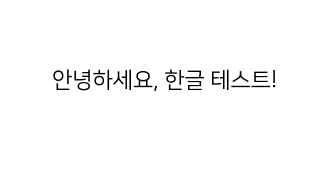

In [10]:
import os
import urllib.request
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='NanumSquare')

# 폰트 설정 확인 (예시 플롯)
plt.figure(figsize=(4,2))
plt.text(0.5, 0.5, "안녕하세요, 한글 테스트!", fontsize=16, ha="center")
plt.axis("off")
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


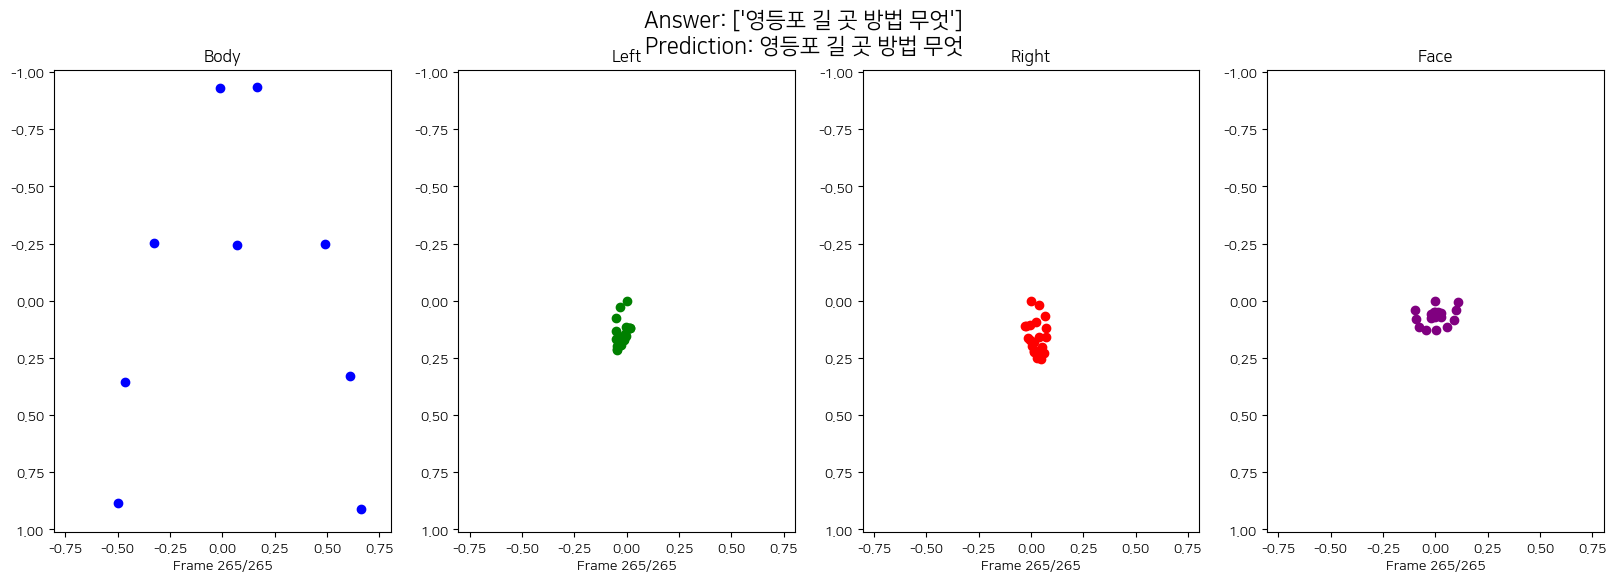

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# 이미 src_input에서 각 key에 대해 배치 차원을 제거한 후 numpy array로 변환했다고 가정합니다.
# body, left, right, face 배열의 shape는 [frames, num_keys, 3]입니다.
body = src_input['body'][0].cpu().numpy()
left = src_input['left'][0].cpu().numpy()
right = src_input['right'][0].cpu().numpy()
face = src_input['face_all'][0].cpu().numpy()

interval = 100        # 프레임 간 간격 (ms)
conf_threshold = 0.0  # confidence threshold (모든 포인트 표시)
frames = body.shape[0]

# 모든 좌표의 최소/최대값 계산 (x, y만 사용)
all_coords = np.concatenate([
    body[..., :2].reshape(-1, 2),
    left[..., :2].reshape(-1, 2),
    right[..., :2].reshape(-1, 2),
    face[..., :2].reshape(-1, 2)
], axis=0)
xmin, ymin = all_coords.min(axis=0)
xmax, ymax = all_coords.max(axis=0)

# 1행 4열의 subplot 생성 (가로로 4개)
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
ax_body, ax_left, ax_right, ax_face = axes

# 각 축에 동일한 좌표 범위 및 y축 반전 적용 (이미지 좌표계와 맞추기 위해)
for ax in axes:
    ax.set_xlim(xmin - 0.01, xmax + 0.01)
    ax.set_ylim(ymin - 0.01, ymax + 0.01)
    ax.invert_yaxis()

# 각 subplot의 제목 설정
ax_body.set_title("Body")
ax_left.set_title("Left")
ax_right.set_title("Right")
ax_face.set_title("Face")

# 각 축에 scatter plot 객체 생성 (초기에는 빈 데이터)
scat_body = ax_body.scatter([], [], c='blue')
scat_left = ax_left.scatter([], [], c='green')
scat_right = ax_right.scatter([], [], c='red')
scat_face = ax_face.scatter([], [], c='purple')

def init():
    empty = np.empty((0, 2))  # (0,2) 형태의 빈 배열
    scat_body.set_offsets(empty)
    scat_left.set_offsets(empty)
    scat_right.set_offsets(empty)
    scat_face.set_offsets(empty)
    return scat_body, scat_left, scat_right, scat_face

def update(frame_idx):
    # confidence threshold를 넘는 좌표만 필터링
    def filter_points(points):
        valid = points[:, 2] > conf_threshold
        return points[valid, :2] if np.any(valid) else np.empty((0, 2))
    
    pts_body = filter_points(body[frame_idx])
    pts_left = filter_points(left[frame_idx])
    pts_right = filter_points(right[frame_idx])
    pts_face = filter_points(face[frame_idx])
    
    scat_body.set_offsets(pts_body)
    scat_left.set_offsets(pts_left)
    scat_right.set_offsets(pts_right)
    scat_face.set_offsets(pts_face)
    
    # 각 subplot에 현재 프레임 정보를 xlabel로 업데이트 (원하는 경우)
    for ax in axes:
        ax.set_xlabel(f"Frame {frame_idx + 1}/{frames}")
    
    return scat_body, scat_left, scat_right, scat_face

# 정답(answer)과 예측(prediction) 텍스트를 전체 애니메이션의 제목(suptitle)으로 설정합니다.
fig.suptitle(f"Answer: {reference}\nPrediction: {predicted_text}", fontsize=16)

ani = animation.FuncAnimation(fig, update, frames=frames, init_func=init,
                              interval=interval, blit=False)

# 애니메이션을 GIF 파일로 저장 (imagemagick 설치 필요)
ani.save('example.gif', writer='imagemagick')
plt.show()
